# COVID-19 Forecasting
Using Long short-term memory (LSTM) - Recurrent Neural Network

**Import Libraries**

In [400]:
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from math import sqrt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from IPython.display import display, HTML
from sklearn.preprocessing import PowerTransformer

In [307]:
!head data/covid-19-all.csv

**Import dataset**

In [390]:
df = pd.read_csv("data/covid-19-all.csv")
df["Confirmed"].fillna(0, inplace = True)
df["Deaths"].fillna(0, inplace = True)
df["Recovered"].fillna(0, inplace = True)
df["Province/State"].fillna('', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

df.dropna(inplace=True)

forecast_date = pd.to_datetime("2020-06-01")
validation_date = pd.to_datetime("2020-05-15")

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295854 entries, 0 to 295854
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Country/Region  295854 non-null  object        
 1   Province/State  295854 non-null  object        
 2   Latitude        295854 non-null  float64       
 3   Longitude       295854 non-null  float64       
 4   Confirmed       295854 non-null  float64       
 5   Recovered       295854 non-null  float64       
 6   Deaths          295854 non-null  float64       
 7   Date            295854 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 20.3+ MB


In [391]:
df

,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths,Date
0,China,Anhui,31.825700,117.226400,1.0,0.0,0.0,2020-01-22
1,China,Beijing,40.182400,116.414200,14.0,0.0,0.0,2020-01-22
2,China,Chongqing,30.057200,107.874000,6.0,0.0,0.0,2020-01-22
3,China,Fujian,26.078900,117.987400,1.0,0.0,0.0,2020-01-22
4,China,Gansu,37.809900,101.058300,0.0,0.0,0.0,2020-01-22
...,...,...,...,...,...,...,...,...
295850,West Bank and Gaza,,31.952200,35.233200,555.0,415.0,3.0,2020-06-17
295851,Western Sahara,,24.215500,-12.885800,9.0,8.0,1.0,2020-06-17
295852,Yemen,,15.552727,48.516388,902.0,271.0,244.0,2020-06-17
295853,Zambia,,-13.133897,27.849332,1412.0,1142.0,11.0,2020-06-17


**Plot actual epicurves**

In [392]:
df['id'] = df['Country/Region'] + df['Province/State']
df = df.groupby(['id','Date','Country/Region'])[['Confirmed','Recovered','Deaths']].sum()
df.reset_index(inplace=True)
df

,id,Date,Country/Region,Confirmed,Recovered,Deaths
0,Afghanistan,2020-02-24,Afghanistan,1.0,0.0,0.0
1,Afghanistan,2020-02-25,Afghanistan,1.0,0.0,0.0
2,Afghanistan,2020-02-26,Afghanistan,1.0,0.0,0.0
3,Afghanistan,2020-02-27,Afghanistan,1.0,0.0,0.0
4,Afghanistan,2020-02-28,Afghanistan,1.0,0.0,0.0
...,...,...,...,...,...,...
44251,Zimbabwe,2020-06-13,Zimbabwe,356.0,54.0,4.0
44252,Zimbabwe,2020-06-14,Zimbabwe,383.0,54.0,4.0
44253,Zimbabwe,2020-06-15,Zimbabwe,387.0,54.0,4.0
44254,Zimbabwe,2020-06-16,Zimbabwe,391.0,62.0,4.0


In [393]:
def plot_country_epicurves(df, country):
    df = df.copy()
    df.Date = pd.to_datetime(df.Date, format = "%Y-%m-%d") 
    df = df.set_index("Date")  
    data = df[df["Country/Region"] ==  country]
    #Sum sub regions daily counts
    data = data.groupby("Date")[["Confirmed", "Deaths", "Recovered"]].sum().reset_index()
    plt.figure(figsize = (12, 5))
    plt.plot(data.Date, data.Confirmed, label = "Confirmed")
    plt.plot(data.Date, data.Recovered, label = "Recovered")
    plt.plot(data.Date, data.Deaths, label = "Deaths")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.legend(frameon = True, fontsize = 12)
    plt.title(country + " COVID-19 cases", fontsize = 35)
    plt.savefig(country + " actual.png")
    plt.show()

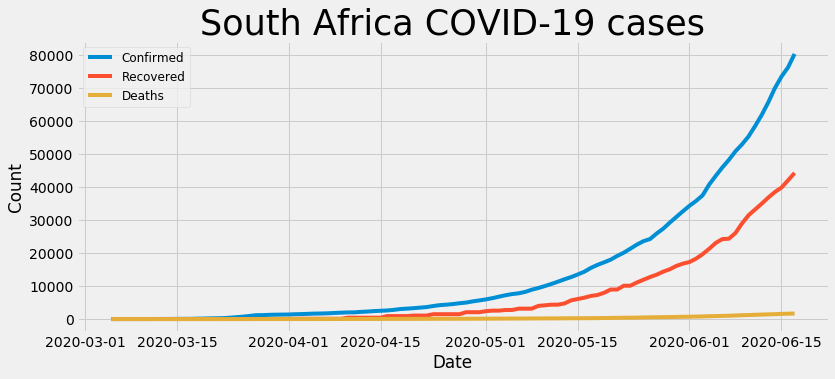

In [394]:
plot_country_epicurves(df, "South Africa")

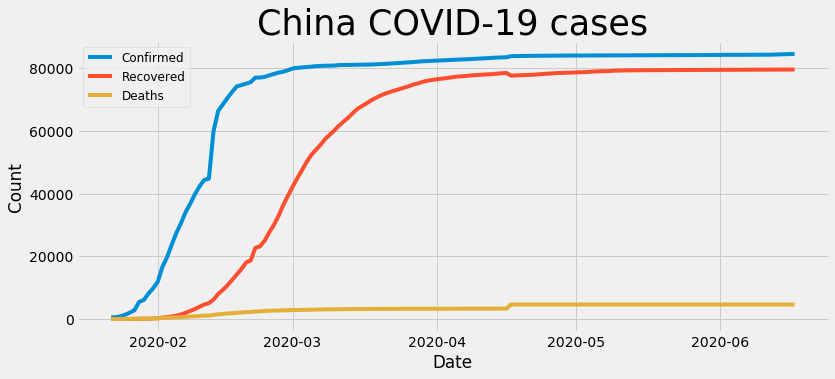

In [329]:
plot_country_epicurves(df, "China")

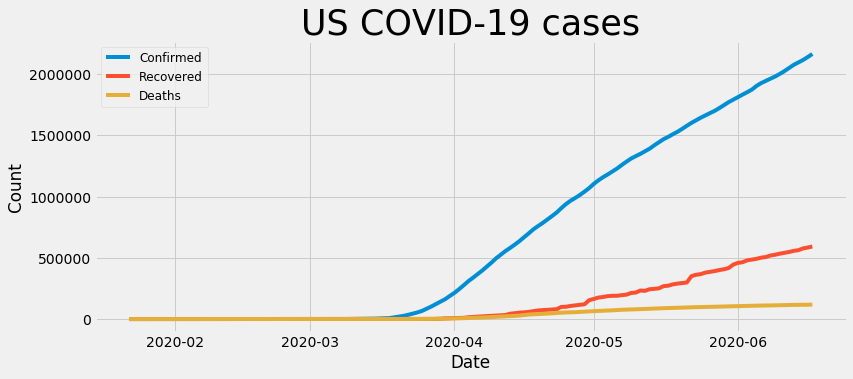

In [330]:
plot_country_epicurves(df, "US")

**Forecast functions**

In [331]:
'''
Analytic functions

'''
def r2(actual, predict):
    '''R-Squared - coefficient of determination,'''
    return r2_score(actual, predict)
    
def smape(actual, predict):
    '''Symmetric mean absolute percentage error'''
    return 100/len(actual.values) * np.sum(2 * np.abs(predict.values - actual.values) / 
         (np.abs(actual.values) + np.abs(predict.values)))

def mae(actual, predict):
    '''Mean absolute error regression loss'''
    return mean_absolute_error(actual, predict)
    
def sampen(data):
    '''Sample Entropy for forecastibility measure'''
    r = 0.2 * np.std(data)
    m = 2
    def _distance(x_1, x_2):
        return max([abs(ua - va) for ua, va in zip(x_1, x_2)])
    def _template(m):
        x = [[data[j] for j in range(i, i + m - 1 + 1)] for i in range(len(data) - m + 1)]
        template_vectors = [len([1 for j in range(len(x)) if i != j and 
                            _distance(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(template_vectors)
    return(-np.log(_template(m + 1) / _template(m)))
    
def analyze_results(train_values, test_values, predict_values):
    df_table = pd.DataFrame()
    df_table["Sample Entropy"] = [sampen(train_values)]
    df_table["R-Squared"]      = [r2(test_values, predict_values)]
    df_table["sMAPE"]          = [smape(test_values, predict_values)]
    df_table["MAE"]            = [mae(test_values, predict_values)]
    display(HTML(df_table.to_html(index = False)))                

In [332]:
def plot_forecast(data, train, forecasts, feature, country):
    plt.figure(figsize = (12, 5))
    data.index = pd.to_datetime(data.index)
    train.index = pd.to_datetime(train.index)
    forecasts.index = pd.to_datetime(forecasts.index)
    plt.plot(data, label = "Observed data")
    plt.plot(train, label = "Smoothed train data")
    plt.plot(forecasts, label = "Forecast")
    plt.legend(loc = "best")
    plt.xticks(rotation = 50)
    plt.title(country + " - " + feature + " cases vs " + " predicitions", fontsize=30)
    plt.show()

In [468]:
def train_valid_test_split(df, validation_date=validation_date, test_date=forecast_date):
    return (df[df["Date"] <= validation_date], 
            df[(df['Date'] > validation_date) & (df['Date'] <= test_date)],
            df[df['Date'] > test_date]
           )

train, valid, test = train_valid_test_split(df)

train_size = train.shape[0]
valid_size = valid.shape[0]
test_size = test.shape[0]

print("Train dataset contains: {} rows".format(train.shape[0]))
print("Validation dataset contains: {} rows".format(valid.shape[0]))
print("Test dataset contains: {} rows".format(test.shape[0]))

Train dataset contains: 25077 rows
Validation dataset contains: 7972 rows
Test dataset contains: 11207 rows


In [540]:
BATCH_SIZE = 32

def make_dataset(df, window_len = 15, ):
    def make_source(df, window_len, ):
        locations = set(df['id'])
        for location in locations:
            cases_per_time = df[df['id'] == location].sort_values('Date')['Confirmed'].to_numpy()
            if len(cases_per_time) < window_len + 2:
                continue
            cases_per_time_dataset = keras.preprocessing.sequence.TimeseriesGenerator(
                cases_per_time, cases_per_time, 
                length=window_len, batch_size=BATCH_SIZE,
            )
            for row in cases_per_time_dataset:
                yield row
    source = lambda: make_source(df, window_len)
    tf_dataset = tf.data.Dataset.from_generator(source, 
                                          output_types=(tf.float32, tf.float32))
    tf_dataset = tf_dataset.map(lambda X, y: (X[...,tf.newaxis], y[...,tf.newaxis]))
    tf_dataset = tf_dataset.shuffle(200).repeat().prefetch(1)
    return tf_dataset


train_data = make_dataset(train, window_len=15)
validation_data = make_dataset(valid, window_len=15)
test_data = make_dataset(test, window_len=15)

sample = next(iter(train_data))
print("X shape is {}, y shape is {}".format(sample[0].shape, sample[1].shape))

X shape is (32, 15, 1), y shape is (32, 1)


In [593]:
def make_model(**model_args):
    model = keras.models.Sequential([
        keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(20, activation='selu')),
        keras.layers.TimeDistributed(keras.layers.Dense(1)),
    ])
    optimizer = keras.optimizers.Adagrad(lr=1e-3)
    model.compile(loss="mse",
                  optimizer=optimizer, 
                  metrics=['mse'],
                 **model_args)
    return model

model = make_model(run_eagerly=True)

In [594]:
history = model.fit(train_data,
          steps_per_epoch=train_size // BATCH_SIZE,
          epochs=30,
          validation_data=validation_data,
         validation_steps=valid_size // BATCH_SIZE)

Epoch 1/2
783/783 [==============================] - 55s 70ms/step - loss: 679086592.0000 - mse: 679086592.0000 - val_loss: 1596763904.0000 - val_mse: 1596763904.0000
Epoch 2/2
783/783 [==============================] - 50s 63ms/step - loss: 695157248.0000 - mse: 695157248.0000 - val_loss: 1027836672.0000 - val_mse: 1027836672.0000


In [605]:
def make_predictions(model, X, duration=30):
    X = np.array(X)[..., np.newaxis]
    predictions = np.empty((duration))
    for step in range(duration):
        prediction = model(X)[0]
        predictions[step] = prediction
        X = np.append(X[1:,...], prediction, axis=0)
    
    return predictions

make_predictions(model, [0., 0., 0., 1., 2., 2., 4., 5.])

array([0.40941888, 0.40941888, 0.40941888, 0.86484808, 1.25416219,
       1.25416219, 1.77194917, 1.92398036, 0.6000188 , 0.6000188 ,
       0.6000188 , 0.80583453, 0.97195488, 0.97195488, 1.17297387,
       1.22761893, 0.68724716, 0.68724716, 0.68724716, 0.77972424,
       0.85269666, 0.85269666, 0.93849736, 0.96106994, 0.72668993,
       0.72668993, 0.72668993, 0.76811004, 0.80047441, 0.80047441])

In [616]:
def plot_difference(timesteps, predicted, actual):
    t_timesteps = range(len(timesteps))
    t_prediction = range(len(predicted))
    plt.plot(t_timesteps, timesteps)
    plt.plot(t_prediction, predicted)
    plt.plot(t_prediction, actual)    
    plt.show()
    

# plot_difference()
def extract_data(df, location_id="USGeorgia", column="Confirmed"):
    column = df[df['id'] == location_id]
    column = column.sort_values('Date')
    
    return column[['Date','Confirmed']].set_index("Date")
     
sample_data = extract_data(df)


,Confirmed
Date,
2020-03-10,17.0
2020-03-11,23.0
2020-03-12,31.0
2020-03-13,42.0
2020-03-14,66.0
...,...
2020-06-13,56804.0
2020-06-14,57681.0
2020-06-15,58414.0


In [451]:
'''
Extract country feature data and use prediction date
as test data starting index

'''
def split_featured_data(df, feature, country, test_date):  
    df = df.copy()
    data = df[df["Country/Region"] == country]
    #Sum sub regions daily counts
    data = data.groupby("Date")[["Confirmed", "Deaths", "Recovered"]].sum().reset_index()
    data = data[["Date", feature]]
    data = data.set_index("Date")  
    data = data.iloc[:, 0]   
    data = data[data.values != 0]
    #Smooth data for train data
    smooved_data = data.rolling(2, min_periods = 1).mean()
    #find date row index
    split_index = np.where(data.index.to_numpy() == test_date)[0][0] 
    train = smooved_data[0:split_index]
    test = data[split_index:len(data)]
    return data.to_frame(), train.to_frame(), test.to_frame()

In [63]:
def lstm(df, feature, country, test_date, plot = True, future_count = 0):
    data, train, test = split_featured_data(df, feature, country, test_date)
    #Scale data
    #scaler = PowerTransformer(method="box-cox").fit(train.values)
    scaler = MinMaxScaler().fit(train.values)
    train_scaled = scaler.transform(train.values)
    test_scaled = scaler.transform(test.values)
    #LTSM model
    n_input = len(test)
    n_features = 1
    generator = TimeseriesGenerator(train_scaled, train_scaled, length = n_input, batch_size = 1)
    
    #Predictions
    lstm_predictions_scaled = []
    batch = train_scaled[-n_input:]
    current_batch = batch.reshape((1, n_input, n_features))
    for i in range(len(test)): 
        lstm_pred = model.predict(current_batch)[0]
        lstm_predictions_scaled.append(lstm_pred) 
        current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]], axis = 1)
    forecasts = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled), columns = [feature])
    
    #Create forecasted dates
    base = datetime.datetime.strptime(test_date, "%Y-%m-%d")
    forecast_dates = [(base - datetime.timedelta(days = -x)).date().strftime("%Y-%m-%d") 
                      for x in range(len(test) + future_count)]
    #Add dates to forecasts
    forecasts["Date"] = forecast_dates
    forecasts = forecasts.set_index("Date")
    
    if plot:
        plot_forecast(data, train, forecasts, feature, country)
    if future_count == 0:
        analyze_results(train.values, test, forecasts)

In [30]:
lstm(df, "Confirmed", "US", forecast_date)

## South Africa LSTM Forecasts

71/71 [==============================] - 0s 4ms/step - loss: 0.0722


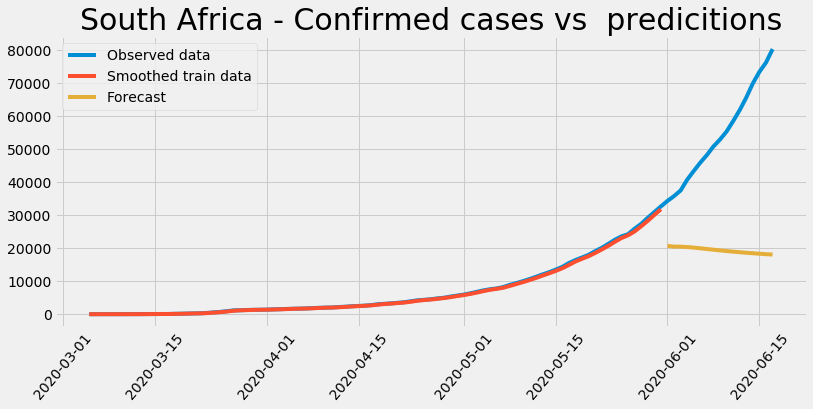

Sample Entropy,R-Squared,sMAPE,MAE
0.037654,-6.348369,91.235728,35435.049686


In [24]:
lstm(df, "Confirmed", "South Africa", forecast_date)

54/54 [==============================] - 0s 4ms/step - loss: 0.0519


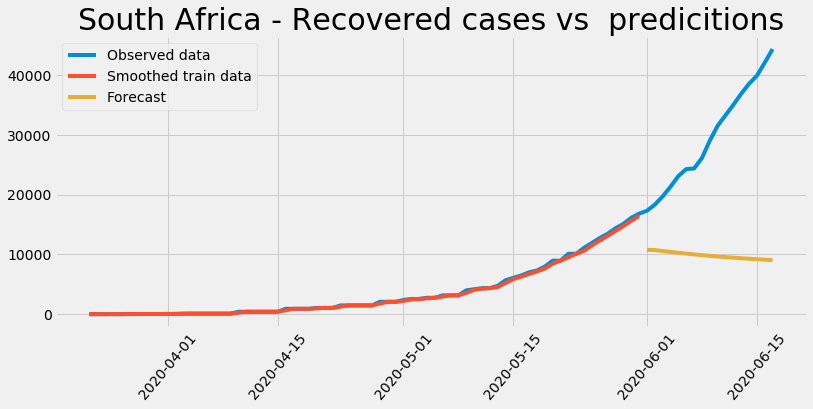

Sample Entropy,R-Squared,sMAPE,MAE
0.068598,-5.662094,95.240795,19862.528895


In [25]:
lstm(df, "Recovered", "South Africa", forecast_date)

49/49 [==============================] - 0s 4ms/step - loss: 0.0758


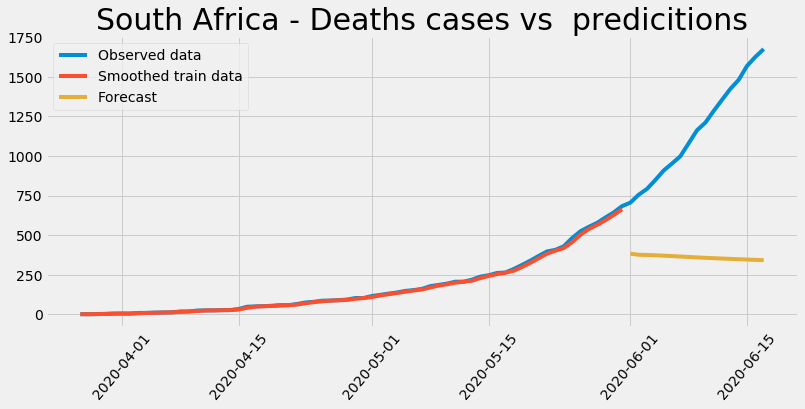

Sample Entropy,R-Squared,sMAPE,MAE
0.062167,-6.90286,101.23248,805.529532


In [26]:
lstm(df, "Deaths", "South Africa", forecast_date)

## Turkey LSTM Forecasts

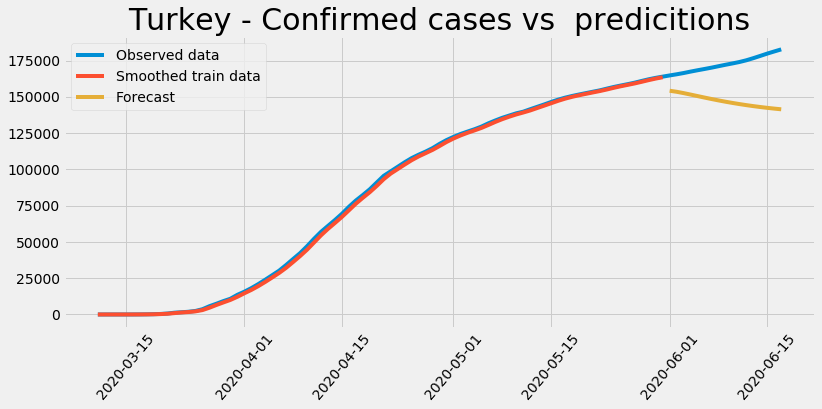

Sample Entropy,R-Squared,sMAPE,MAE
0.055399,-24.104029,15.932014,25522.443605


In [26]:
lstm(df, "Confirmed", "Turkey", forecast_date)

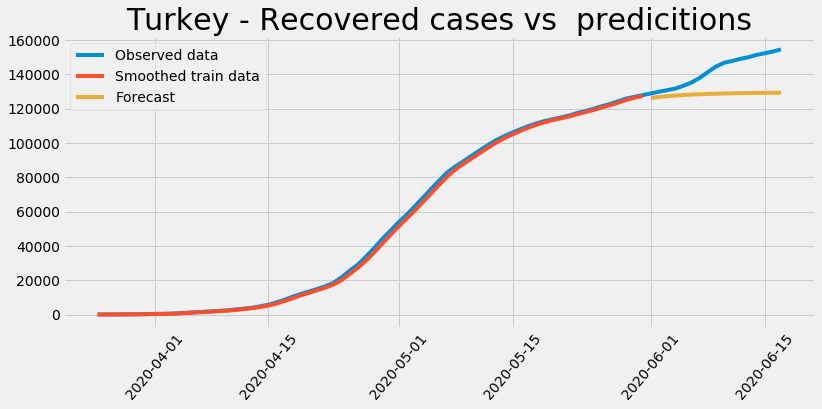

Sample Entropy,R-Squared,sMAPE,MAE
0.069152,-2.254838,10.045483,13875.49701


In [27]:
lstm(df, "Recovered", "Turkey", forecast_date)

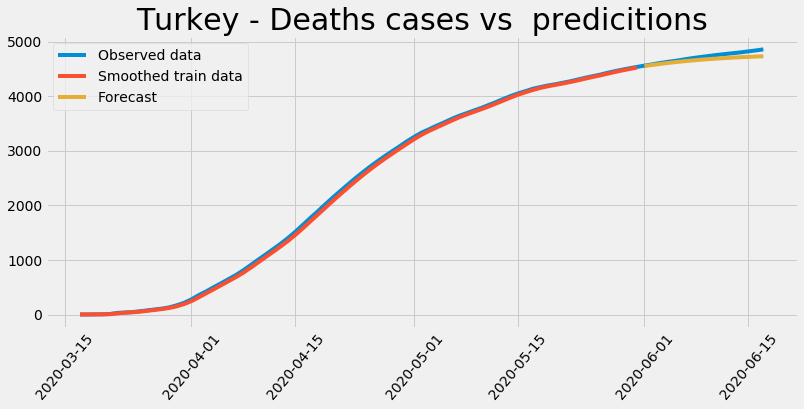

Sample Entropy,R-Squared,sMAPE,MAE
0.060472,0.444013,1.190203,56.37179


In [28]:
lstm(df, "Deaths", "Turkey", forecast_date)

## USA LSTM Forecasts

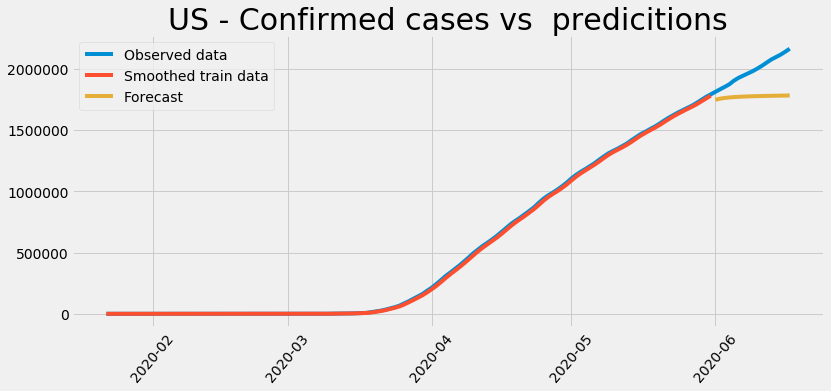

Sample Entropy,R-Squared,sMAPE,MAE
0.028975,-3.799895,11.165007,212526.221279


In [29]:
lstm(df, "Confirmed", "US", forecast_date)

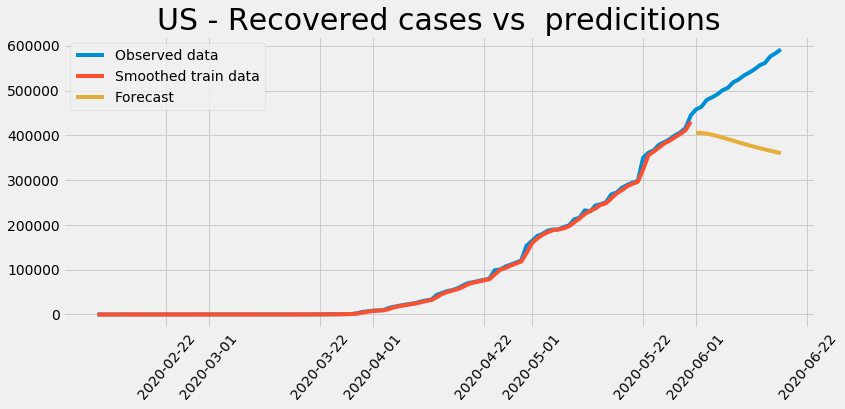

Sample Entropy,R-Squared,sMAPE,MAE
0.037615,-12.935474,30.500501,140108.902826


In [30]:
lstm(df, "Recovered", "US", forecast_date)

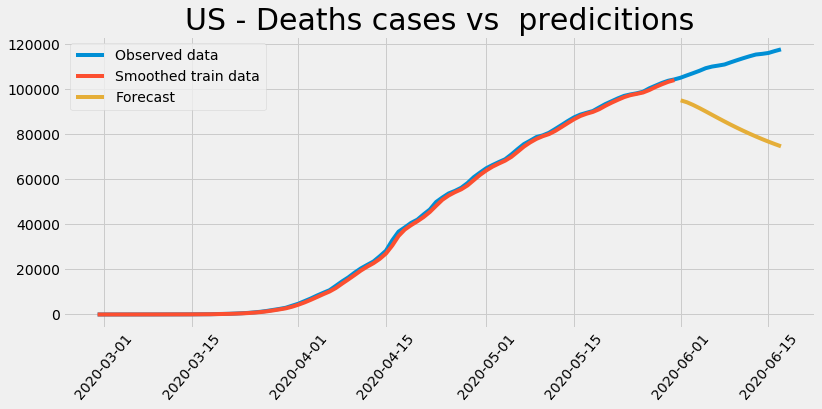

Sample Entropy,R-Squared,sMAPE,MAE
0.0555,-58.51973,27.944453,27316.290617


In [31]:
lstm(df, "Deaths", "US", forecast_date)